In [1]:
!pip install prophet

<ipython-input-2-654333688>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("/content/Athens_meteo.csv", parse_dates=['DAY'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpadnvvpgh/36pkji10.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpadnvvpgh/0bna1fst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44729', 'data', 'file=/tmp/tmpadnvvpgh/36pkji10.json', 'init=/tmp/tmpadnvvpgh/0bna1fst.json', 'output', 'file=/tmp/tmpadnvvpgh/prophet_modelxqzhmc1v/prophet_model-20250614150949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:09:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:09:49 - cmdstanpy - INFO - Chain [1] done processing

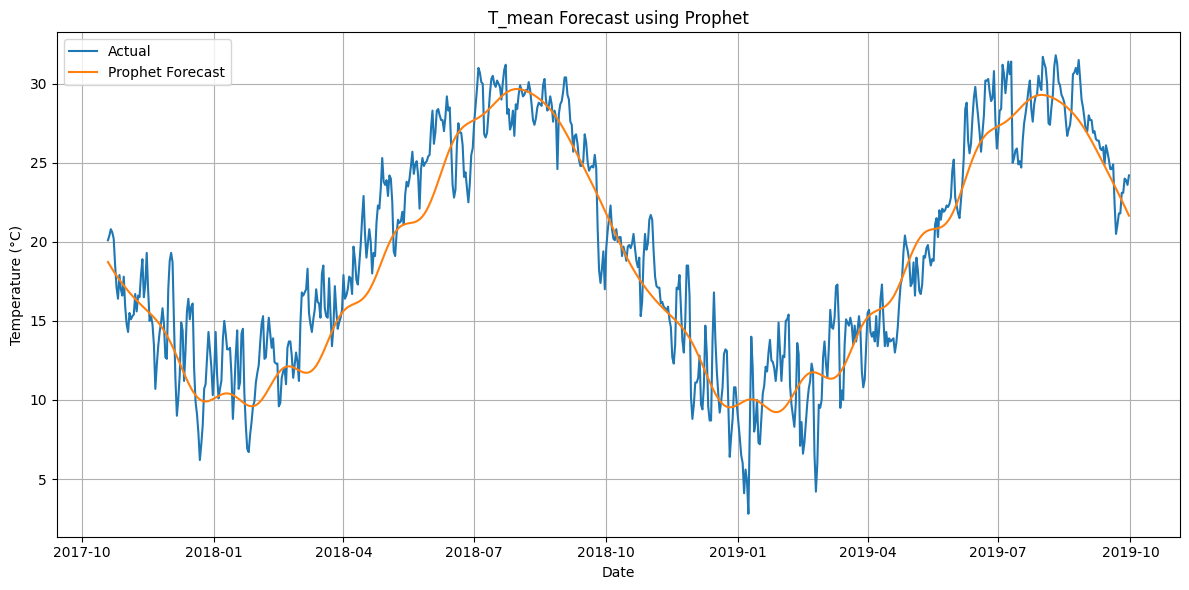

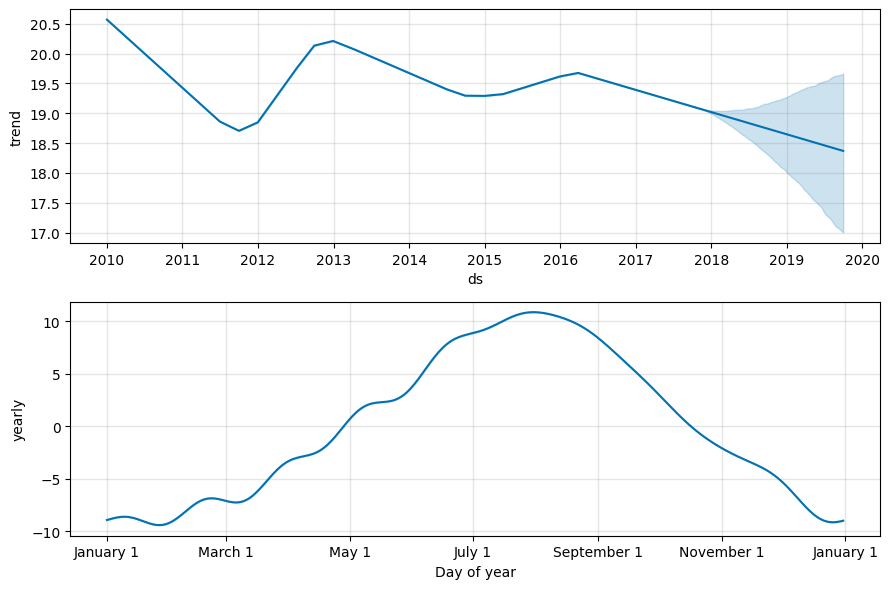


📊 Prophet Performance on Test Set
MAE : 1.98 °C
RMSE: 2.47 °C
R²  : 0.876


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ─────────────────────────────────────────────────────────────
# Load and prepare data
df = pd.read_csv("/content/Athens_meteo.csv", parse_dates=['DAY'])
df = df[['DAY', 'T_mean']]
df.dropna(inplace=True)

# Prophet expects columns: ds (date) and y (target)
df_prophet = df.rename(columns={'DAY': 'ds', 'T_mean': 'y'})

# Chronological split (80% train / 20% test)
split_index = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_index]
test_df = df_prophet.iloc[split_index:]

# ─────────────────────────────────────────────────────────────
# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False
)
model.fit(train_df)

# Forecast into the future (same length as test set)
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

# ─────────────────────────────────────────────────────────────
# Evaluate only on the test period
forecast_test = forecast.iloc[-len(test_df):]
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# ─────────────────────────────────────────────────────────────
# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_true, label='Actual')
plt.plot(test_df['ds'], y_pred, label='Prophet Forecast')
plt.title('T_mean Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# Prophet built-in components plot
model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Print evaluation
print("\n Prophet Performance on Test Set")
print(f"MAE : {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")
print(f"R²  : {r2:.3f}")
